In [2]:
# importing some libraries
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

In [3]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

100%|██████████| 135M/135M [00:03<00:00, 40.2MB/s]


In [4]:
# extracting the file from archive to a data folder in the current directory

with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

Now we will Analyse the datasets

The dataset is extracted to the directory data/cifar10. It contains 2 folders train and test, containing the training set (50000 images) and test set (10000 images) respectively. Each of them contains 10 folders, one for each class of images.

In [5]:
file_list = os.listdir('/content/data/cifar10')
print(file_list)

['test', 'train']


In [6]:
classes = os.listdir('/content/data/cifar10/train')
print(classes)

['airplane', 'bird', 'horse', 'automobile', 'dog', 'cat', 'frog', 'deer', 'truck', 'ship']


In [7]:
airplane_files = os.listdir('/content/data/cifar10/test/airplane')
print(  "No of airplane files in the test data set",len(airplane_files))

No of airplane files in the test data set 1000


In [8]:
print(airplane_files[1])

0633.png


In [9]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [10]:
dataset = ImageFolder('/content/data/cifar10/train', transform=ToTensor())


In [11]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [12]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [13]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  airplane (0)


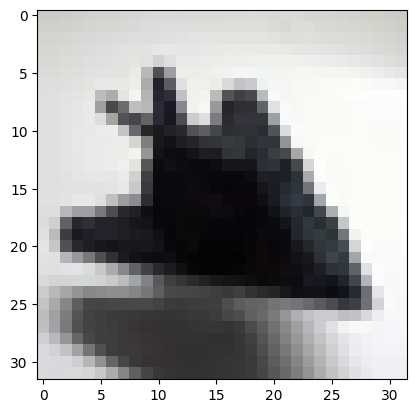

In [14]:
show_example(*dataset[0])

In [15]:
img, label = dataset[0]
print(img.shape)
img


torch.Size([3, 32, 32])


tensor([[[0.7922, 0.7922, 0.8000,  ..., 0.8118, 0.8039, 0.7961],
         [0.8078, 0.8078, 0.8118,  ..., 0.8235, 0.8157, 0.8078],
         [0.8235, 0.8275, 0.8314,  ..., 0.8392, 0.8314, 0.8235],
         ...,
         [0.8549, 0.8235, 0.7608,  ..., 0.9529, 0.9569, 0.9529],
         [0.8588, 0.8510, 0.8471,  ..., 0.9451, 0.9451, 0.9451],
         [0.8510, 0.8471, 0.8510,  ..., 0.9373, 0.9373, 0.9412]],

        [[0.8000, 0.8000, 0.8078,  ..., 0.8157, 0.8078, 0.8000],
         [0.8157, 0.8157, 0.8196,  ..., 0.8275, 0.8196, 0.8118],
         [0.8314, 0.8353, 0.8392,  ..., 0.8392, 0.8353, 0.8275],
         ...,
         [0.8510, 0.8196, 0.7608,  ..., 0.9490, 0.9490, 0.9529],
         [0.8549, 0.8471, 0.8471,  ..., 0.9412, 0.9412, 0.9412],
         [0.8471, 0.8431, 0.8471,  ..., 0.9333, 0.9333, 0.9333]],

        [[0.7804, 0.7804, 0.7882,  ..., 0.7843, 0.7804, 0.7765],
         [0.7961, 0.7961, 0.8000,  ..., 0.8039, 0.7961, 0.7882],
         [0.8118, 0.8157, 0.8235,  ..., 0.8235, 0.8157, 0.

In [16]:
random_seed =42
torch.manual_seed(random_seed)

In [17]:
val_size=5000
train_size = len(dataset)-val_size
train_ds,val_ds=random_split(dataset,[train_size,val_size])
len(train_ds),len(val_ds)

(45000, 5000)

In [18]:
from torch.utils.data.dataloader import DataLoader
batch_size=128
train_dl = DataLoader(train_ds,batch_size,shuffle=True,num_workers=2,pin_memory=True)
val_dl = DataLoader(val_ds,batch_size*2,num_workers=2,pin_memory=True)

In [19]:
from torchvision.utils import make_grid

def show_batch(dl):
  for images,labels in dl:
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images,nrow=16).permute((1,2,0)))
    break

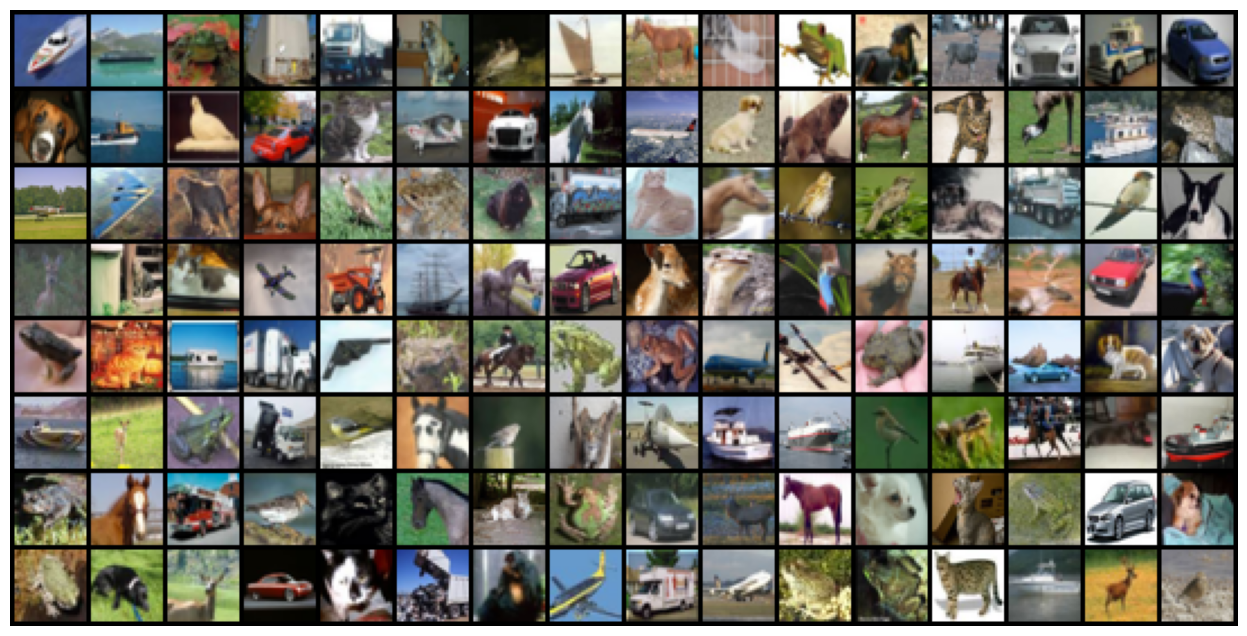

In [20]:
show_batch(train_dl)

Defining the Convolutional neural network model

In [21]:
import torch.nn as nn
import torch.nn.functional as F

In [22]:
class ImageClassificationBase(nn.Module):
  def training_step(self,batch):
    images,labels = batch
    out=self(images)  # generate predictions
    loss =F.cross_entropy(out,labels) # calculating loss
    return loss

  def validation_step(self,batch):
    images,labels = batch
    out = self(images) # generate predictions
    loss = F.cross_entropy(out,labels) #calculate loss
    acc = accuracy(out,labels) # calculate accuracy
    return {'val_loss':loss.detach(),'val_acc':acc}

  def validation_epoch_end(self,outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean() # combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean() # combine accuracies
    return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}


  def epoch_end(self,epoch,result):
    print("Epoch [{}],,train_loss: {:.4f},val_loss: {:.4f},val_  acc: {:.4f}".format(
        epoch,result['train_loss'],result['val_loss'],result['val_acc']))

def accuracy(outputs,labels):
  _,preds = torch.max(outputs,dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [23]:
class Cifar10CnnModel(ImageClassificationBase):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(3,32,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), # output : 64 x 16 x 16

        nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output: 128 x 8 x 8

        nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output: 256 x 4 x 4

        nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
  def forward(self,xb):
    return self.network(xb)

In [24]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [25]:
# Move the model to the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for images, labels in train_dl:
    # Move the input to the GPU
    images = images.to(device)

    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 10])
out[0]: tensor([ 0.0438, -0.0268, -0.0092,  0.0336,  0.0270,  0.0127, -0.0411,  0.0360,
         0.0166, -0.0212], device='cuda:0', grad_fn=<SelectBackward0>)


In [26]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [27]:
device = get_default_device()
device

device(type='cuda')

In [28]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [29]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [30]:
model = to_device(Cifar10CnnModel(), device)

In [31]:

evaluate(model, val_dl)

{'val_loss': 2.302919864654541, 'val_acc': 0.0963350161910057}

In [32]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [33]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0],,train_loss: 1.7982,val_loss: 1.4393,val_  acc: 0.4639
Epoch [1],,train_loss: 1.2727,val_loss: 1.1152,val_  acc: 0.5959
Epoch [2],,train_loss: 1.0182,val_loss: 0.9500,val_  acc: 0.6660
Epoch [3],,train_loss: 0.8530,val_loss: 0.8446,val_  acc: 0.6959
Epoch [4],,train_loss: 0.7275,val_loss: 0.8069,val_  acc: 0.7211
Epoch [5],,train_loss: 0.6213,val_loss: 0.7622,val_  acc: 0.7311
Epoch [6],,train_loss: 0.5369,val_loss: 0.7301,val_  acc: 0.7553
Epoch [7],,train_loss: 0.4605,val_loss: 0.6923,val_  acc: 0.7697
Epoch [8],,train_loss: 0.3935,val_loss: 0.7293,val_  acc: 0.7676
Epoch [9],,train_loss: 0.3263,val_loss: 0.7988,val_  acc: 0.7642


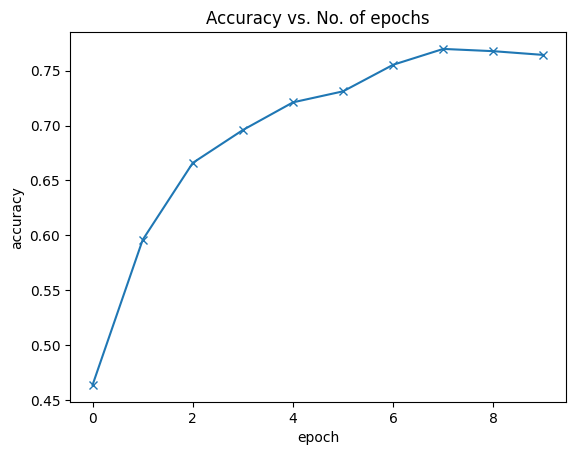

In [34]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');


plot_accuracies(history)

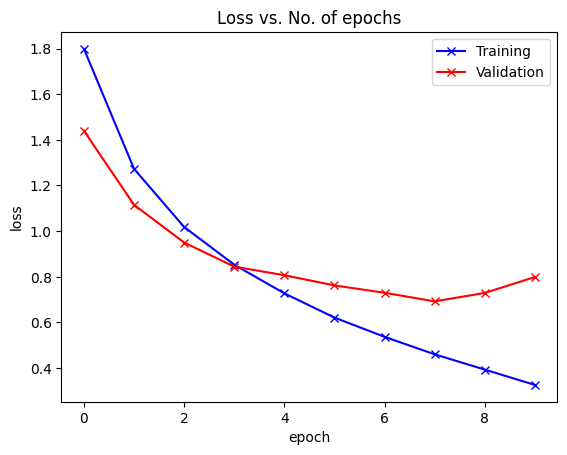

In [35]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');


plot_losses(history)

Since we've trained our model for a long time and achieved a resonable accuracy, it would be a good idea to save the weights of the model to disk, so that we can reuse the model later and avoid retraining from scratch. Here's how you can save the model.

In [36]:
torch.save(model.state_dict(), 'Image-Classification-using-CNN.pth')


In [37]:
model2 = to_device(Cifar10CnnModel(), device)

In [38]:
model2.load_state_dict(torch.load('Image-Classification-using-CNN.pth'))

<All keys matched successfully>

In [39]:
{'val_loss': 0.9219207763671875, 'val_acc': 0.7637695074081421}

{'val_loss': 0.9219207763671875, 'val_acc': 0.7637695074081421}

In [44]:
# Define the prediction function
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick the class with the highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

# Select and test an image (e.g., the first image in the test dataset)
img, label = dataset[1]
print('Actual label:', dataset.classes[label])
print('Predicted label:', predict_image(img, model2))

Actual label: airplane
Predicted label: airplane


In [42]:
img, label = dataset[0]

Label:  automobile (1)


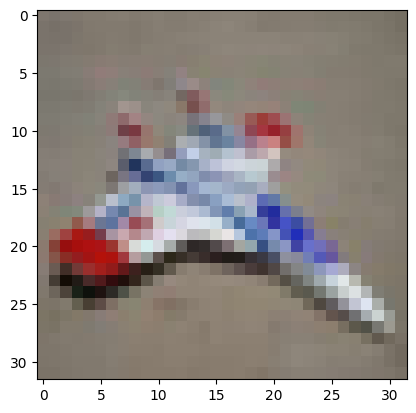

In [45]:
show_example(img,1)